# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 6

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()

In [2]:
# This is needed to render the plots in this chapter
from plots.chapter6 import *

In [3]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, \
ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

# Rock, Paper, Scissors

## Rock Paper Scissors Dataset

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

In [4]:
# This may take a couple of minutes...
download_rps()

rps folder already exists!
rps-test-set folder already exists!


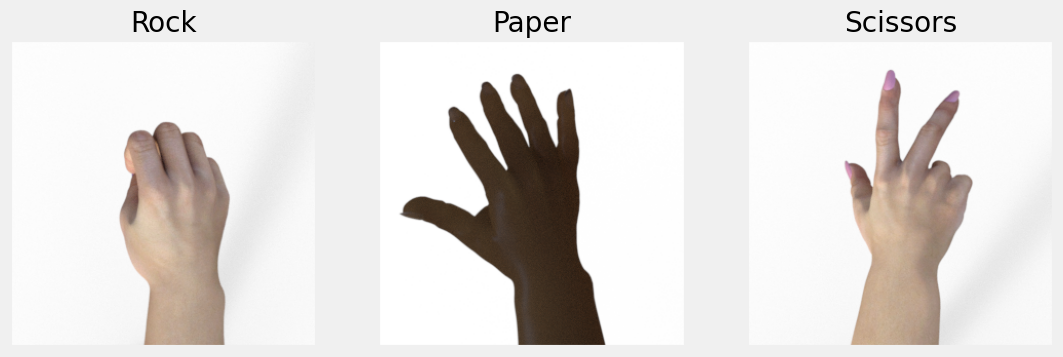

In [5]:
fig = figure1()

# Data Preparation

## ImageFolder

In [6]:
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

In [7]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

## Standardization

In [8]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [9]:
@staticmethod
def statistics_per_channel(images, labels):
    # NCHW
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten HW into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)

    # Computes statistics of each image per channel
    # Average pixel value per channel 
    # (n_samples, n_channels)
    means = flatten_per_channel.mean(axis=2)
    # Standard deviation of pixel values per channel
    # (n_samples, n_channels)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    # Makes a tensor of shape (1, n_channels)
    # with the number of samples in the mini-batch
    n_samples = torch.tensor([n_samples]*n_channels).float()
    
    # Stack the three tensors on top of one another
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [10]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [11]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [12]:
@staticmethod
def make_normalizer(loader):
    total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
    norm_mean = total_means / total_samples
    norm_std = total_stds / total_samples
    return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

In [13]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

### The Real Datasets

In [14]:
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

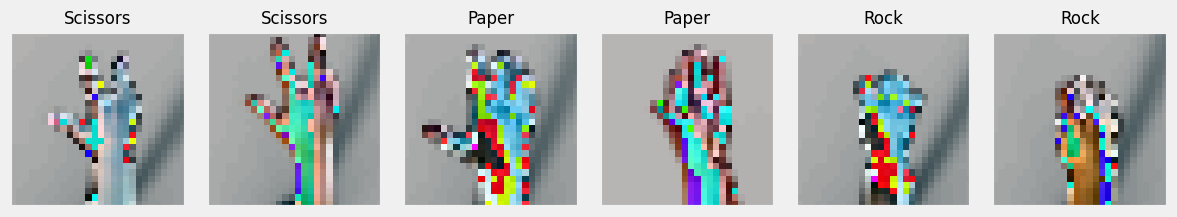

In [15]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

## Convolutions Over Multiple Channels

![](./images/3channel1.png)

![](./images/3channel2.png)

In [16]:
regions = np.array([[[[5, 0, 8],
                      [1, 9, 5],
                      [6, 0, 2]],
                     [[0, 5, 4],
                      [8, 1, 9],
                      [4, 8, 1]],
                     [[4, 2, 0],
                      [6, 3, 0],
                      [5, 2, 8]]]])
regions.shape

(1, 3, 3, 3)

In [17]:
three_channel_filter = np.array([[[[0, 3, 0],
                                   [1, 0, 1],
                                   [2, 1, 0]],
                                  [[2, 1, 0],
                                   [0, 3, 1],
                                   [1, -1, 0]],
                                  [[0, 1, 3],
                                   [-1, -2, 0],
                                   [2, 0, 1]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [18]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[39]]]]), torch.Size([1, 1, 1, 1]))

![](./images/3channel_filters1.png)

## Fancier Model

In [19]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50) 
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)
        
    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x
    
    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x
                
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Dropout

In [20]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [21]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [22]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.0000, 0.6000, 0.8000, 0.0000, 0.0000, 1.4000, 0.0000, 1.8000,
        2.0000, 2.2000])

![](images/dropout_paper.png)

In [23]:
output_train / spaced_points

tensor([0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2.])

In [24]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(8.8000)

In [25]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [26]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [27]:
torch.manual_seed(17)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p), 
                                         weight=torch.ones(11), bias=torch.tensor(0)) 
                                for _ in range(1000)])

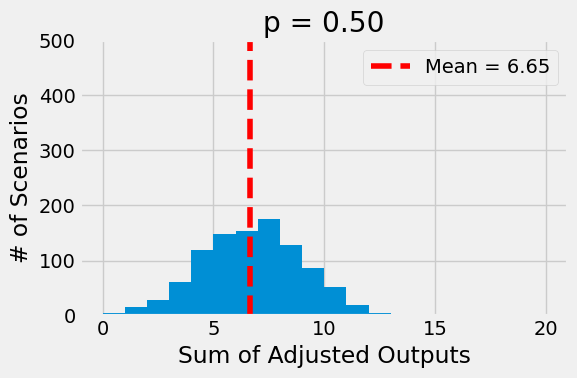

In [28]:
fig = figure7(p, distrib_outputs)

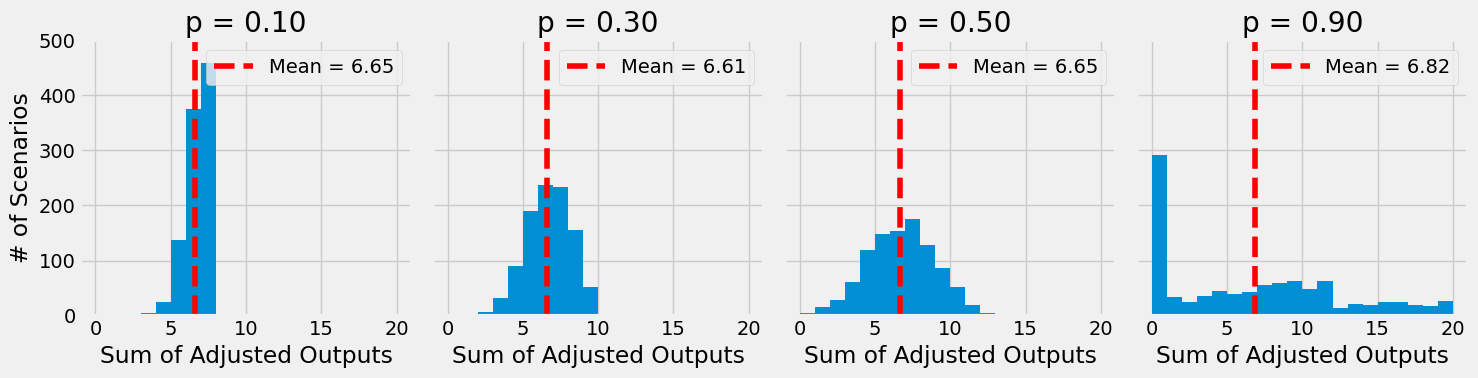

In [29]:
fig = figure8()

### Two-Dimensional Dropout

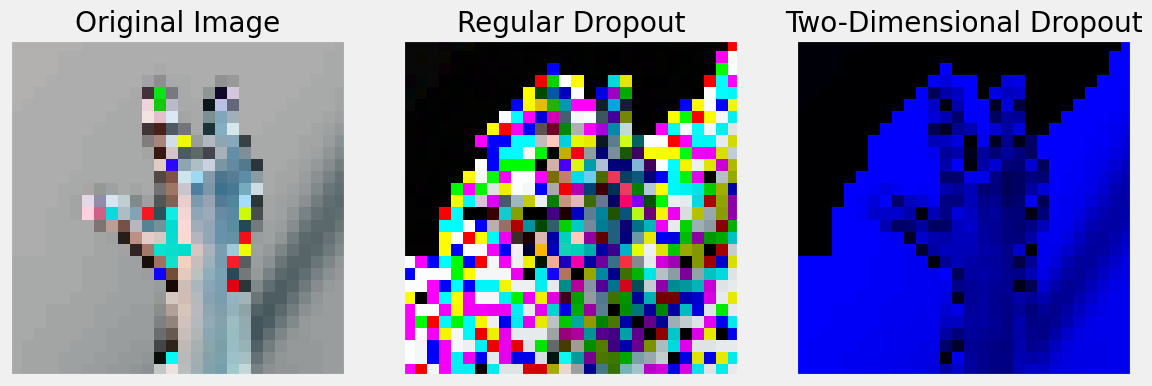

In [30]:
fig = figure9(first_images)

## Model Configuration

In [31]:
torch.manual_seed(13)
model_cnn2 = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

## Model Training

In [32]:
sbs_cnn2 = StepByStep(model_cnn2, multi_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

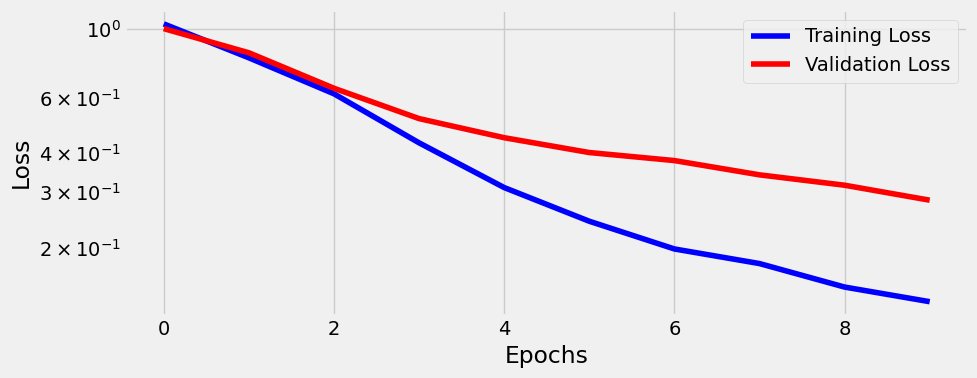

In [33]:
fig = sbs_cnn2.plot_losses()

### Accuracy

In [34]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 87, 124],
        [118, 124],
        [111, 124]])

### Regularizing Effect

In [35]:
torch.manual_seed(13)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
sbs_cnn2_nodrop = StepByStep(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
sbs_cnn2_nodrop.set_loaders(train_loader, val_loader)
sbs_cnn2_nodrop.train(10)

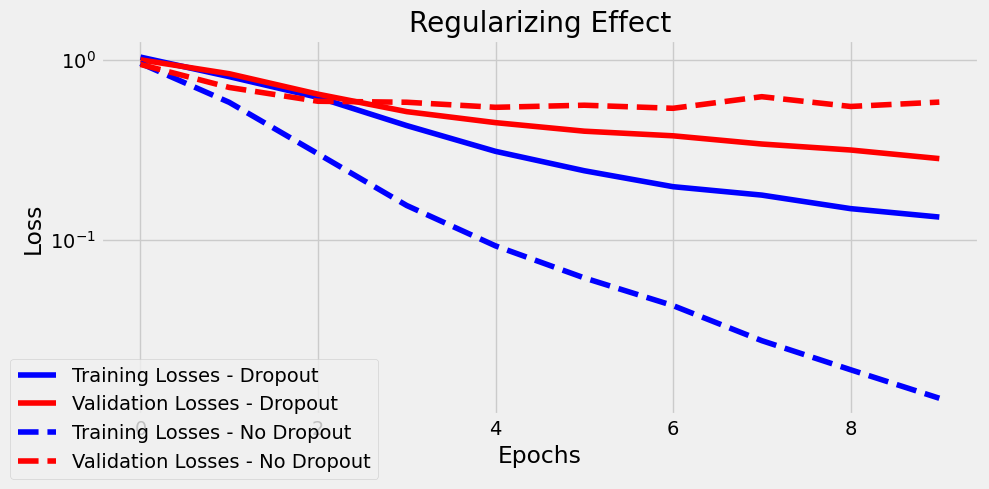

In [36]:
fig = figure11(sbs_cnn2.losses, sbs_cnn2.val_losses, sbs_cnn2_nodrop.losses, sbs_cnn2_nodrop.val_losses)

In [37]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2_nodrop.correct).sum(axis=0), 
    StepByStep.loader_apply(val_loader, sbs_cnn2_nodrop.correct).sum(axis=0)
)

tensor([2520, 2520]) tensor([294, 372])


In [38]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2.correct).sum(axis=0),
    StepByStep.loader_apply(val_loader, sbs_cnn2.correct).sum(axis=0)
)

tensor([2498, 2520]) tensor([316, 372])


### Visualizing Filters

In [39]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

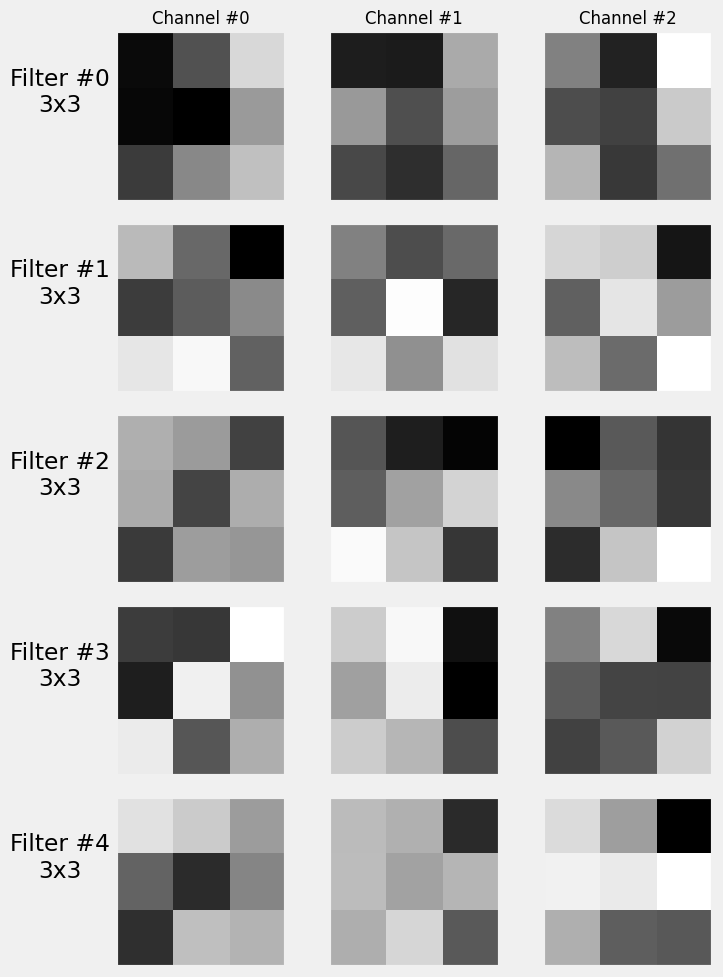

In [40]:
fig = sbs_cnn2.visualize_filters('conv1')

In [41]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

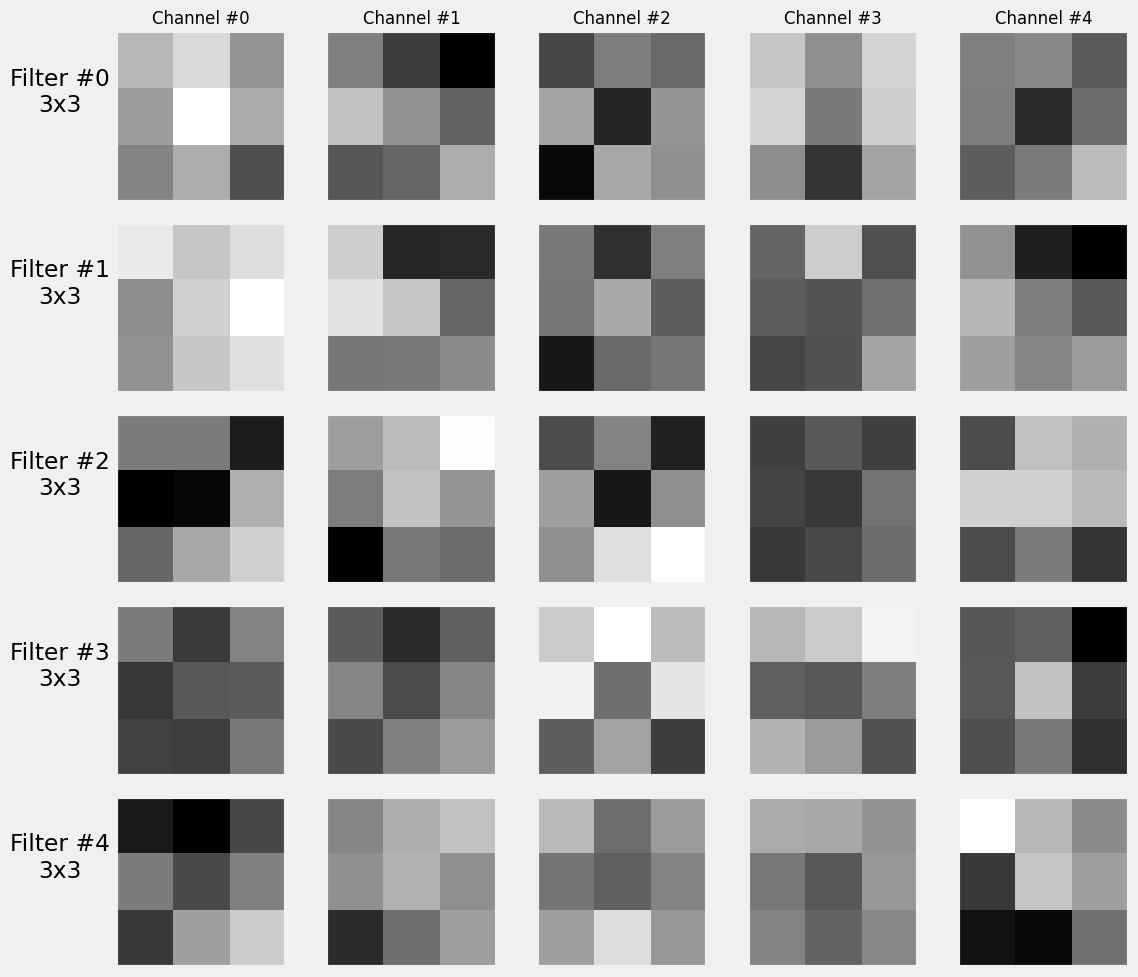

In [42]:
fig = sbs_cnn2.visualize_filters('conv2')

## Learning Rates

### Finding LR

In [43]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter    
        def lr_fn(iteration):
            return np.exp(factor)**iteration    
    return lr_fn

In [44]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [45]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [46]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [47]:
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [48]:
dummy_optimizer.step()
dummy_scheduler.step()

In [49]:
dummy_scheduler.get_last_lr()[0]

0.012589254117941673

In [50]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()), 
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
    
    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(StepByStep, 'lr_range_test', lr_range_test)

In [51]:
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

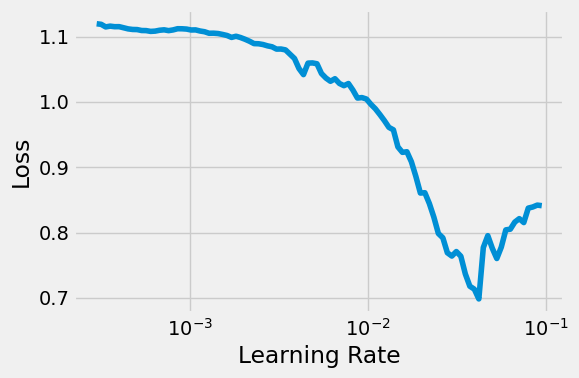

In [52]:
sbs_new = StepByStep(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [53]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer
    
setattr(StepByStep, 'set_optimizer', set_optimizer)

In [54]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

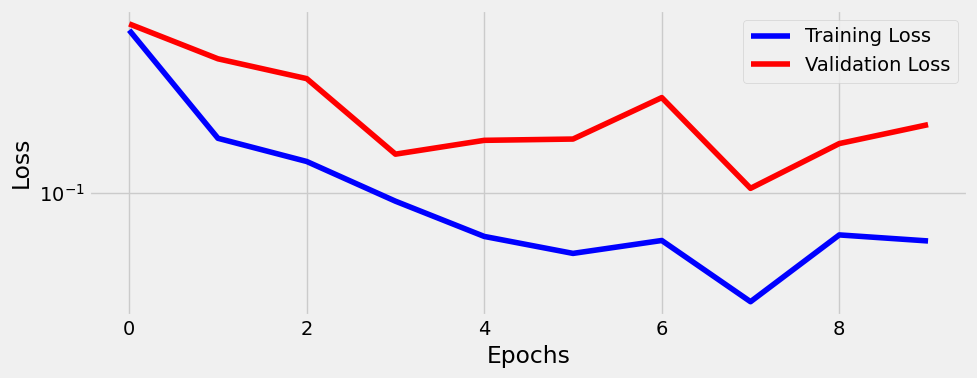

In [55]:
# This plot wasn't included in the book
fig = sbs_new.plot_losses()

### LRFinder

In [57]:
#!pip install --quiet torch-lr-finder
from torch_lr_finder import LRFinder

/Users/norman/env/pytorchbook/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.55E-03


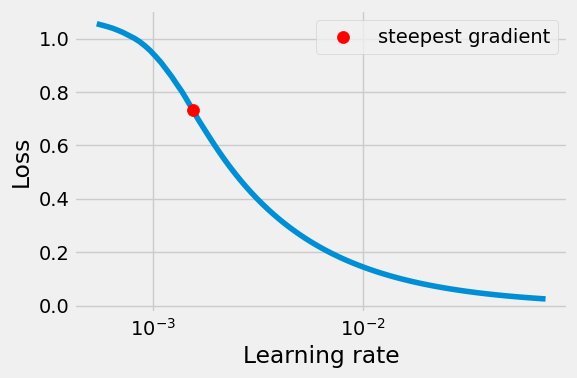

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

### Adaptive Learning Rate

#### Moving Average (MA)

$$
\large
\text{MA}_t(\text{periods}, x) = \frac{1}{\text{periods}}(x_t + x_{t-1} + \ldots + x_{t-\text{periods}+1})
$$

$$
\large
\text{average age}_{\text{MA}} = \frac{1+2+\cdots+\text{periods}}{\text{periods}} = \frac{\text{periods}+1}{2}
$$

#### EWMA

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) = &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{EWMA}_t(\beta, x) = &(1-\beta) &x_t &+ &\beta &\text{EWMA}_{t-1}(\beta, x)
\end{array}
$$

$$
\large
\begin{array}
&\text{EWMA}_t(\alpha, x) &= &&\alpha x_t &+& (1-\alpha)\ (\alpha x_{t-1} &+& (1-\alpha)\ \ \text{EWMA}_{t-2}(\alpha, x))
\\
&= &&\alpha x_t &+& (1-\alpha)\ \ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} + \ldots
\\
&= &\ (1-\alpha)^0& \alpha x_{t-0} &+& (1-\alpha)^1\ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} + \ldots
\\
&= \alpha& ((1-\alpha)^0&\ \ x_{t-0} &+& (1-\alpha)^1\ \ \ x_{t-1} &+& (1-\alpha)^2\ \ x_{t-2} + \ldots)
\\
\end{array}
$$

$$
\large
\text{EWMA}_t(\alpha, x) = \alpha \sum_{\text{lag}=0}^{T-1}\underbrace{(1-\alpha)^{\text{lag}}}_{\text{weight}} x_{t-\text{lag}}
$$

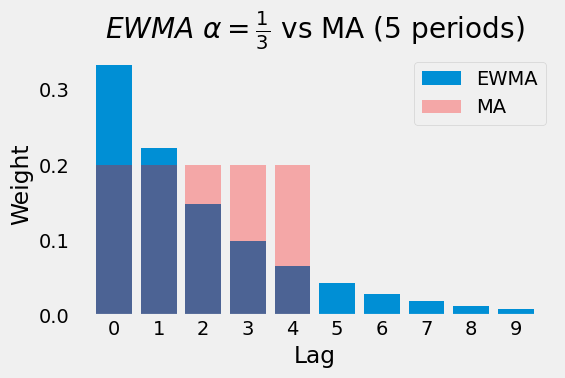

In [59]:
fig = figure15()

$$
\large
\text{average age}_{\text{EWMA}} = \alpha \sum_{\text{lag}=0}^{T-1}(1-\alpha)^{\text{lag}} (\text{lag}+1) \approx \frac{1}{\alpha}
$$

In [60]:
alpha = 1/3; T = 93
t = np.arange(1, T + 1)
age = alpha * sum((1 - alpha)**(t - 1) * t)
age

3.0

$$
\large
\text{average age} = \frac{\text{periods} + 1}{2} = \frac{1}{\alpha} \implies \alpha = \frac{2}{\text{periods}+1};\ \text{periods} = \frac{2}{\alpha}-1
$$

In [61]:
def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

In [62]:
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

$$
\large \text{Bias Corrected EWMA}_t(x, \beta) = \frac{1}{1 - \beta^t}\text{EWMA}_t(x, \beta)
$$

In [63]:
def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

In [64]:
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)
    
    alpha = 2 / (period + 1)
    beta = 1 - alpha
    
    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)
        
    return np.array(result)

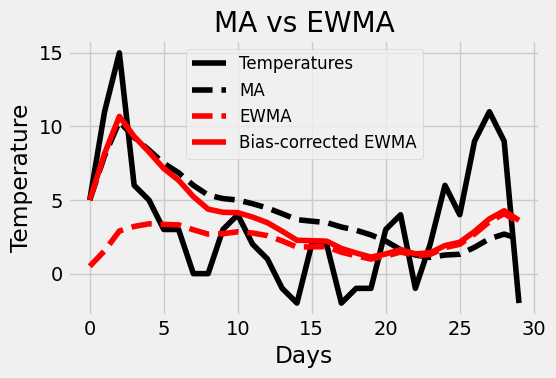

In [65]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1, 
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])

fig = ma_vs_ewma(temperatures, periods=19)

#### EWMA Meets Gradients

$$
\large \text{adapted-gradient}_t = \frac{\text{Bias Corrected EWMA}_t(\beta_1, \text{gradients})}{\sqrt{\text{Bias Corrected EWMA}_t(\beta_2, \text{gradients}^2)}+\epsilon}
$$

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\end{aligned}
$$

#### Adam

In [66]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

#### Visualizing Adapted Gradients

In [67]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py

In [68]:
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')

In [69]:
setattr(StepByStep, '_gradients', {})

def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    self._gradients = {}
    
    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return

setattr(StepByStep, 'capture_gradients', capture_gradients)

In [70]:
sbs_adam = StepByStep(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader, val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

In [71]:
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

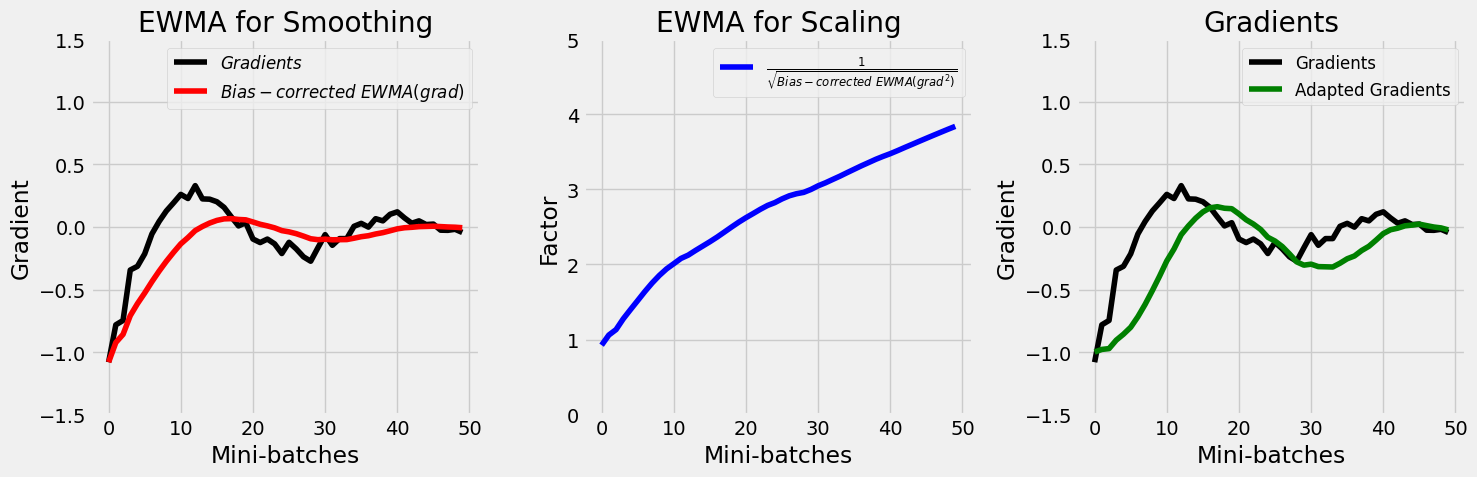

In [72]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

In [73]:
optimizer.state_dict()

{'state': {0: {'step': tensor(50.),
   'exp_avg': tensor([[-0.0062]]),
   'exp_avg_sq': tensor([[0.0033]])},
  1: {'step': tensor(50.),
   'exp_avg': tensor([0.0405]),
   'exp_avg_sq': tensor([0.0097])}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [74]:
calc_ewma(gradients, 19)[-1], calc_ewma(np.power(gradients, 2), 1999)[-1]

(-0.006161449065842973, 0.0033084667431545573)

In [75]:
setattr(StepByStep, '_parameters', {})

def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules}
    
    self._parameters = {}
    
    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name: {}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})
            
    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())
    
    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return
    
setattr(StepByStep, 'capture_parameters', capture_parameters)

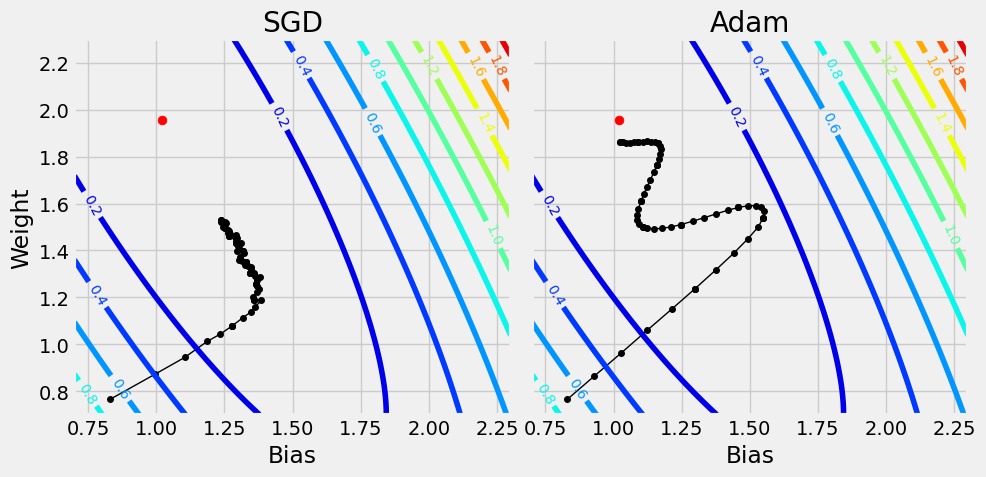

In [76]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
             'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

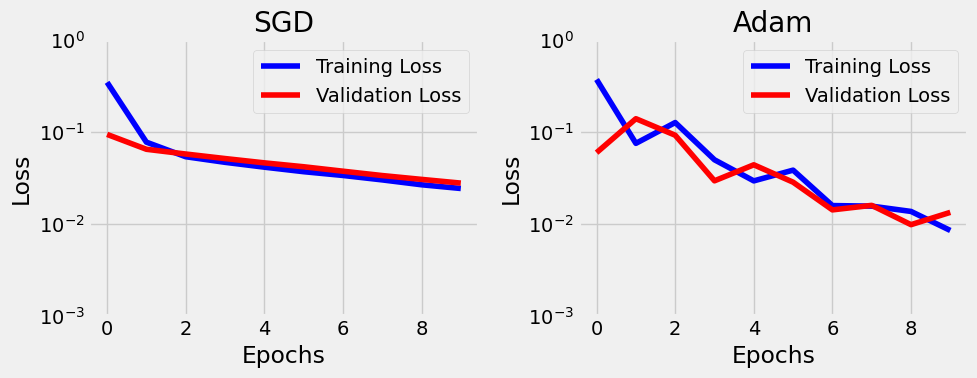

In [77]:
fig = plot_losses(results)

### Momentum

$$
\Large
\begin{array}
&\text{EWMA}_t &= (1-\beta) &\text{grad}_t &+ &\beta &\text{EWMA}_{t-1}
\\
\text{momentum}_t &= &\text{grad}_t &+ &\beta &\text{momentum}_{t-1}
\end{array}
$$

$$
\Large
\text{momentum}_t = \beta^0\ \text{grad}_t + \beta^1\ \text{grad}_{t-1} + \beta^2\ \text{grad}_{t-2} + \ldots + \beta^n\ \text{grad}_{t-n}
$$

$$
\Large \text{momentum}_t = (1-\text{damp})\ \text{grad}_t + \beta\ \text{momentum}_{t-1}
$$

$$
\Large
\begin{aligned}
\text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{momentum}_t
\end{aligned}
$$

In [78]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
             'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

In [79]:
results['SGD + Momentum']['state']

{'state': {0: {'momentum_buffer': tensor([[-0.0308]])},
  1: {'momentum_buffer': tensor([-0.1423])}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

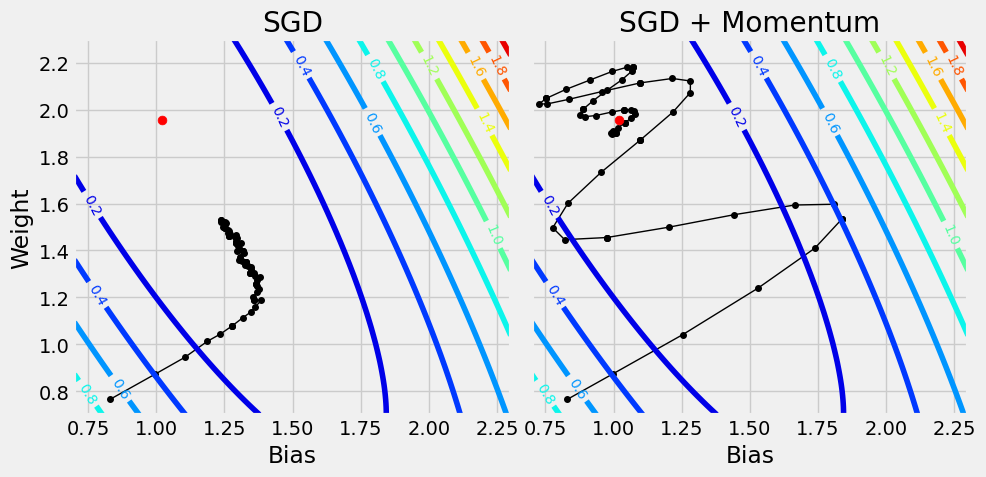

In [80]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

#### Nesterov

$$
\Large
\begin{array}
&\text{step t}: &&&&&&\text{mo}_t &= &\text{grad}_t &+ &\beta &\text{mo}_{t-1}
\\
\text{step t+1}: &\text{mo}_{t+1} &= &\text{grad}_{t+1} &+ &\beta &\text{mo}_{t}
\end{array}
$$

$$
\Large
\begin{array}
&\text{step t}: &&&&&&\text{mo}_t &= &\text{grad}_t &+ &\beta &\text{mo}_{t-1}
\\
\text{step t}: &\text{nesterov}_t &= &\text{grad}_t &+ &\beta &\text{mo}_t&
\\
\text{step t+1}: &\text{mo}_{t+1} &= &\text{grad}_{t+1} &+ &\beta &\text{mo}_{t}
\end{array}
$$

$$
\Large
\begin{aligned}
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\end{aligned}
$$

$$
\Large
\begin{aligned}
\text{param}_t & = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\\
& = \text{param}_{t-1} - \eta\ (\text{grad}_t + \beta\ \text{mo}_t)
\\
& = \text{param}_{t-1} - \eta\ \text{grad}_t - \beta\ \eta\ \text{mo}_t
\end{aligned}
$$

#### Flavors of SGD

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} &&&-&& \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t &-&\beta &\eta\ \text{mo}_t
\end{aligned}
$$

In [81]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}}, 
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

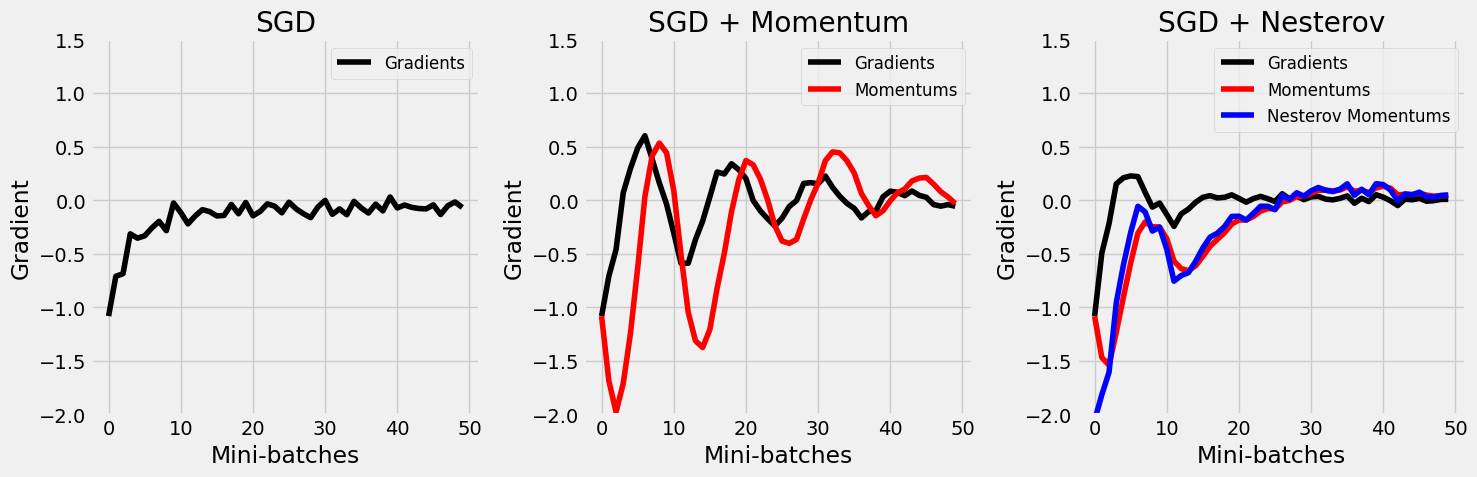

In [82]:
fig = figure21(results)

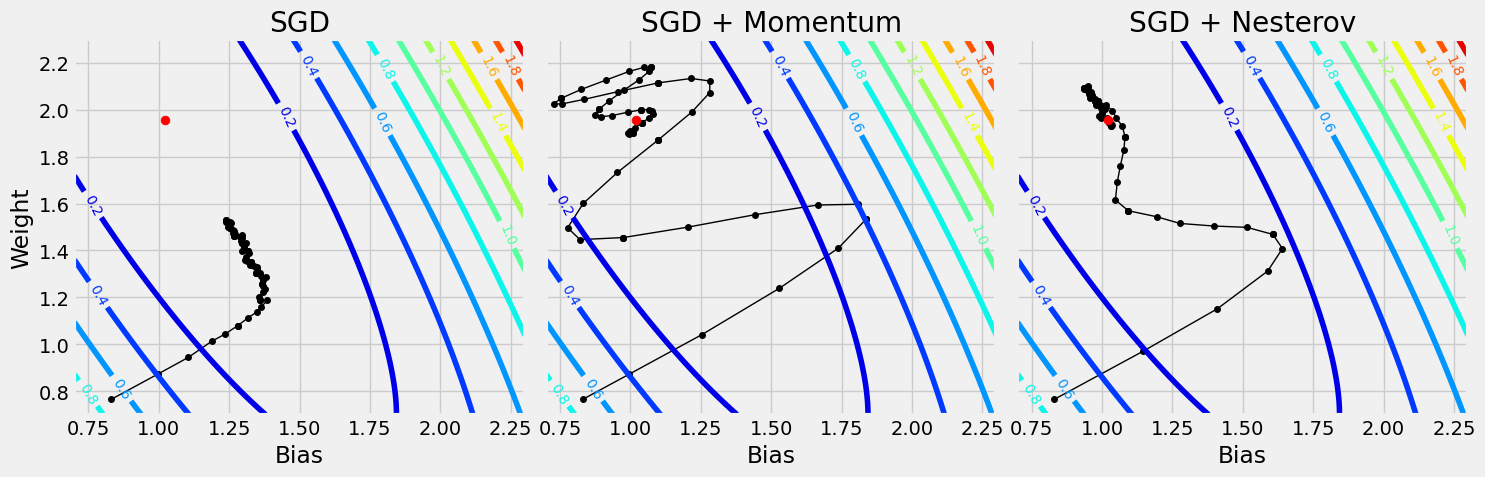

In [83]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

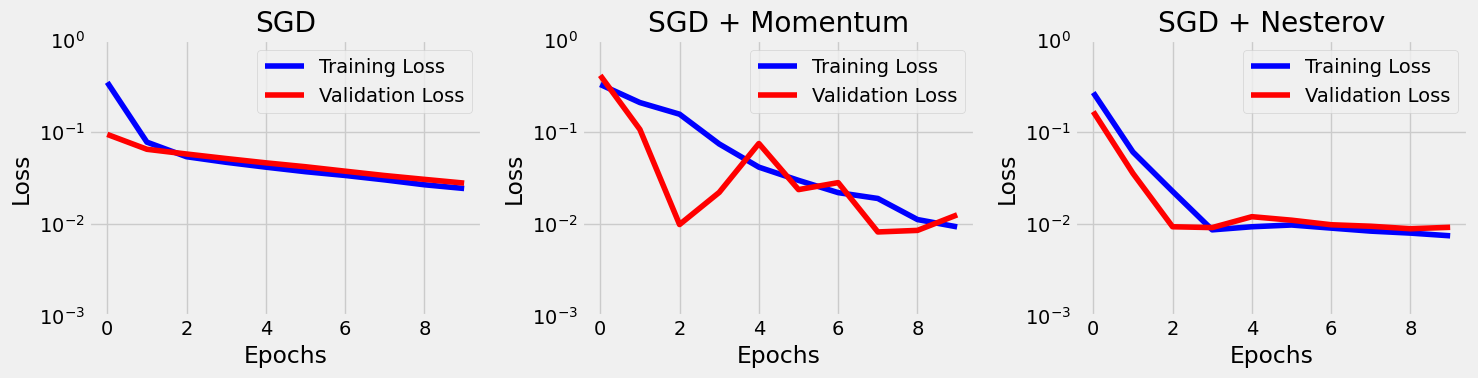

In [84]:
fig = plot_losses(results)

### Learning Rate Schedulers

In [85]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

In [86]:
for epoch in range(4):
    # trainin loop code goes here
    
    print(dummy_scheduler.get_last_lr())
    # First call optimizer's step
    dummy_optimizer.step()
    # Then call scheduler's step
    dummy_scheduler.step()
    
    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


### Epoch Schedulers

In [87]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))
# The scheduler above is equivalent to this one
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

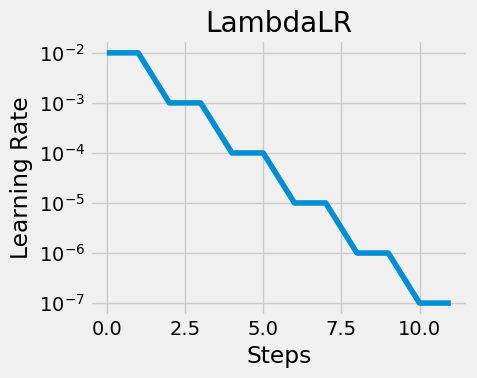

In [88]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Validation Loss Scheduler

In [89]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

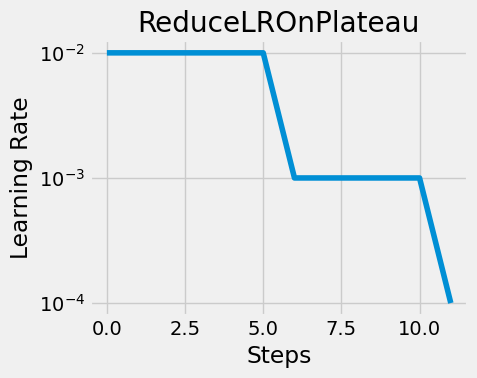

In [90]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Scheduler in StepByStep - Part I

In [91]:
setattr(StepByStep, 'scheduler', None)
setattr(StepByStep, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(StepByStep, 'set_lr_scheduler', set_lr_scheduler)

In [92]:
setattr(StepByStep, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_epoch_schedulers', _epoch_schedulers)

In [93]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        self._epoch_schedulers(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Closes the writer
        self.writer.close()

setattr(StepByStep, 'train', train)

### Mini-Batch Schedulers

In [94]:
dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(.5))

/Users/norman/Data Science/PyTorchStepByStep/plots/chapter6.py:323: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/Users/norman/Data Science/PyTorchStepByStep/plots/chapter6.py:337: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


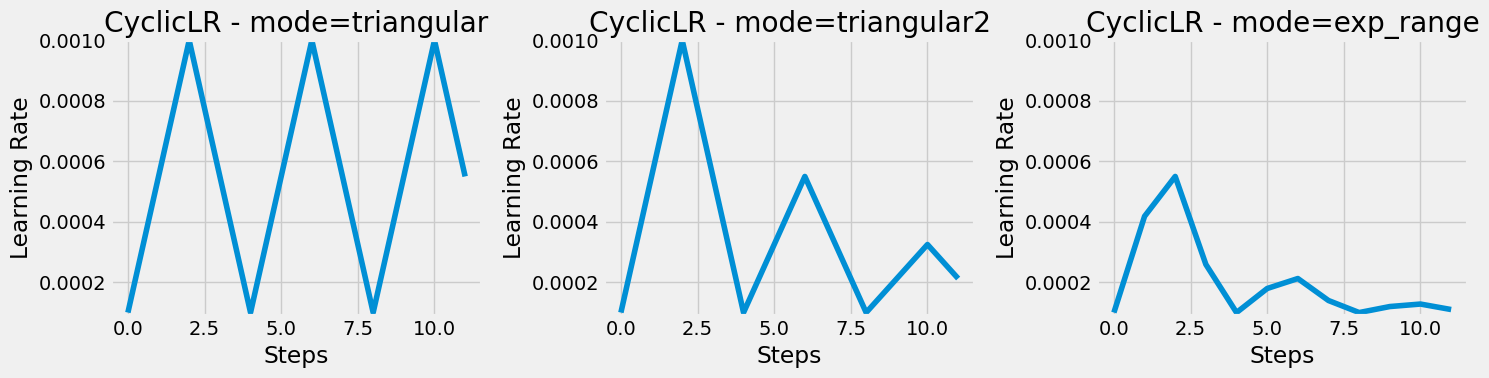

In [95]:
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

### Schedulers in StepByStep - Part II

In [96]:
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_mini_batch_schedulers', _mini_batch_schedulers)

In [97]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and 
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

### Scheduler Paths

/Users/norman/Data Science/PyTorchStepByStep/stepbystep/v3.py:547: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


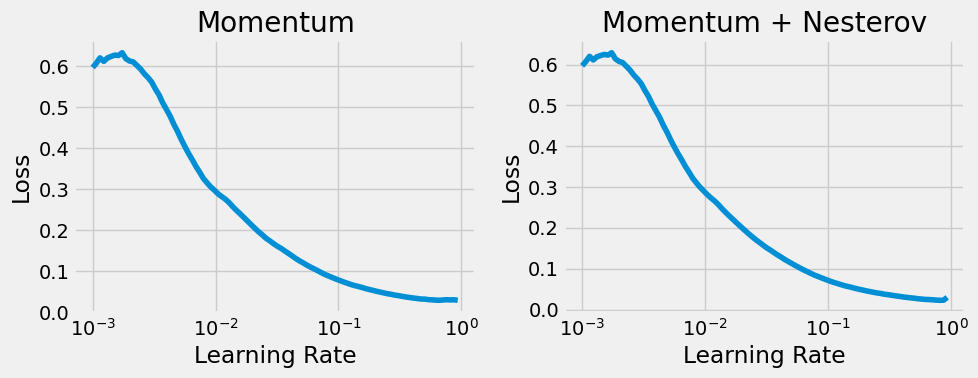

In [98]:
from stepbystep.v3 import StepByStep

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = StepByStep(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)
        
    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [99]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [100]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

/Users/norman/Data Science/PyTorchStepByStep/plots/chapter6.py:406: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


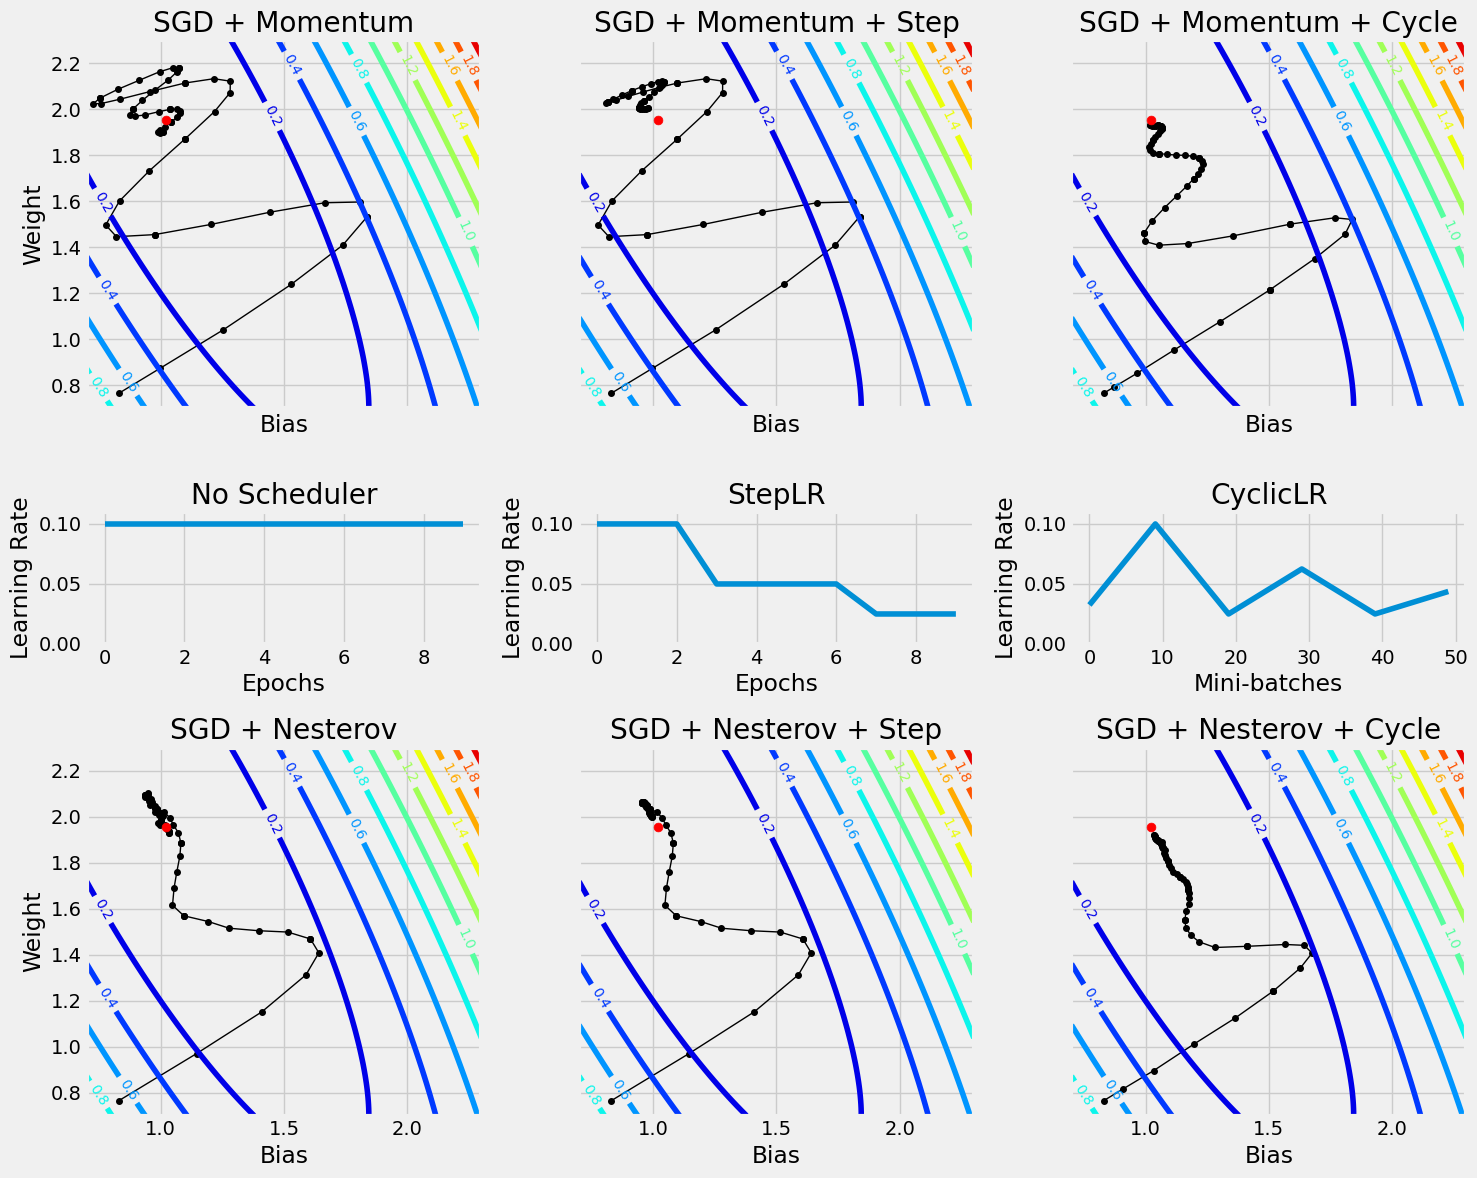

In [101]:
fig = figure28(results, b, w, bs, ws, all_losses)

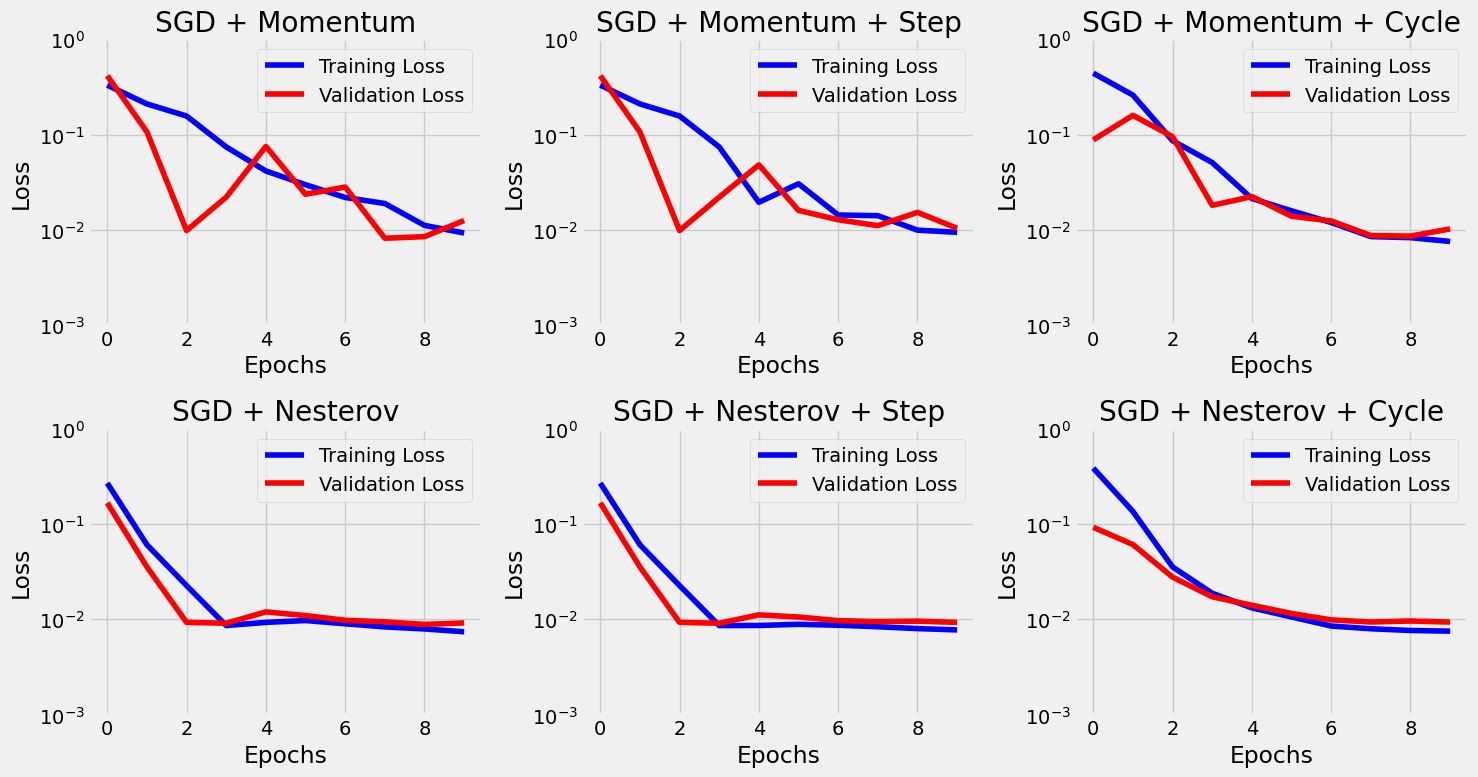

In [102]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

# Putting It All Together

In [103]:
# Loads temporary dataset to build normalizer
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = StepByStep.make_normalizer(temp_loader)

# Builds transformation, datasets and data loaders
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [104]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

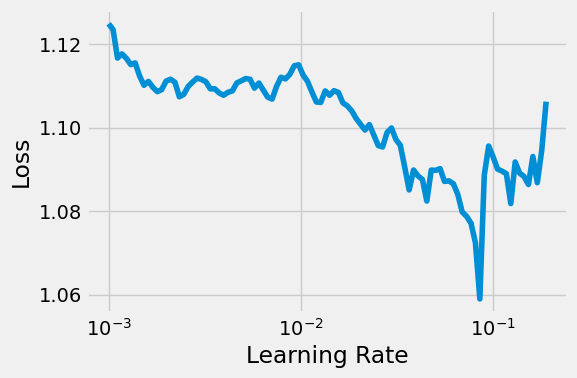

In [105]:
sbs_cnn3 = StepByStep(model_cnn3, multi_loss_fn, optimizer_cnn3)
tracking, fig = sbs_cnn3.lr_range_test(train_loader, end_lr=2e-1, num_iter=100)

In [106]:
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
sbs_cnn3.set_optimizer(optimizer_cnn3)

scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn3.set_lr_scheduler(scheduler)

In [107]:
sbs_cnn3.set_loaders(train_loader, val_loader)
sbs_cnn3.train(10)

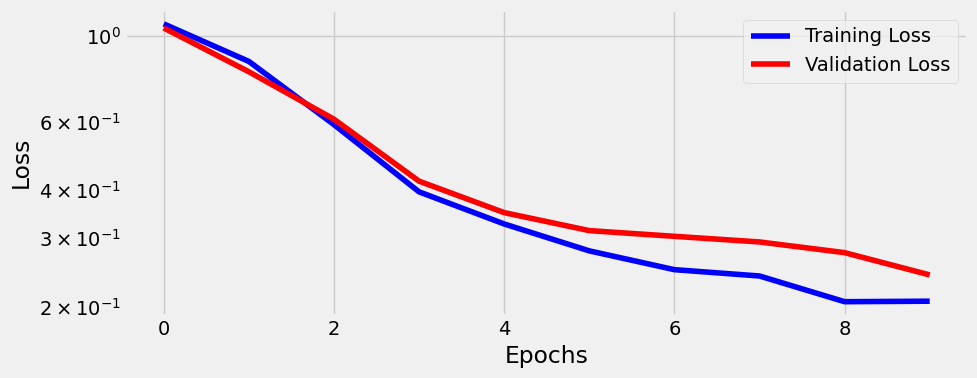

In [108]:
fig = sbs_cnn3.plot_losses()

In [109]:
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))

tensor([2512, 2520]) tensor([335, 372])
